State body definition

In [22]:
from typing_extensions import TypedDict
from typing import List, Literal

class AggregationState(TypedDict):
    uploaded_tables: List[str]
    selected_tables: List[str]
    aggregation_columns: List[str]
    selected_columns: List[str]
    selected_operations: List[Literal["COUNT", "SUM", "AVG", "MIN", "MAX"]]
    time_aggregation: Literal["HOUR", "WEEKDAY", "WEEK", "MONTH", "QUARTER", "NONE"]
    user_prompt: str

In [ ]:
# util functions for the state operations
def get_new_data():
    return ""

def upload_new_data(new_data, state):
    tables = extract_tables(new_data)
    state["uploaded_tables"] = tables

def extract_tables(new_data):
    return []

def extract_columns_from_selected_tables(selected_tables):
    return []

def perform_data_aggregation():
    result = input("Do you want to perform the data aggregation")
    if result.lower() == "yes":
        return "extract_tables"
    else:
        return "sql"
    
def first_fun():
    result = input("Do you want to upload new data")
    if result.lower() == "yes":
        return "continue"
    else:
        return "sql"

In [24]:
# functions for the state nodes
def starting_point(state: AggregationState):
    print("Demo as for the staring point")

    
def load_new_data(state: AggregationState):
    new_data = get_new_data()
    upload_new_data(new_data, state)
    
def extract_tables_state(state: AggregationState):
    print(state["uploaded_tables"])
    selected_tables = input("Please select the desired tables")
    state["selected_tables"] = selected_tables
    columns = extract_columns_from_selected_tables(selected_tables)
    print(columns)
    aggregated_columns = input("Choose the columns on which you want to perform the aggregation")
    state["aggregation_columns"] = aggregated_columns

def state_choose_column(state: AggregationState):
    columns = extract_columns_from_selected_tables(state["selected_tables"])
    operations = ["COUNT", "SUM", "AVG", "MIN", "MAX"]
    print(columns)
    print(operations)
    res_columns = input("Select th desired fields which should be used for aggregation")
    res_operations = input("Select the desired operations for selected columns")
    state["selected_columns"] = res_columns
    state["selected_operations"] = res_operations

def state_time_aggregation(state: AggregationState):
    print(["HOUR", "WEEKDAY", "WEEK", "MONTH", "QUARTER", "Not needed"])
    res = input("Select the desired time aggregation")
    if res == "Not needed":
        state["time_aggregation"] = "NONE"
    else:
        state["time_aggregation"] = res

def state_user_prompt(state: AggregationState):
    state["user_prompt"] = input('Please describe what you wanna have')

def generate_sql(state: AggregationState):
    return ""

Graph definition

In [28]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(AggregationState)
graph.add_node("first_call", starting_point)
graph.add_node("data_loader", load_new_data)
graph.add_node("table_extractor", extract_tables_state)
graph.add_node("column_extractor", state_choose_column)
graph.add_node("time_aggregator", state_time_aggregation)
graph.add_node("state_user_prompt", state_user_prompt)
graph.add_node("sql_generator", generate_sql)

graph.add_edge(START, "first_call")
graph.add_conditional_edges(
    "first_call",
    first_fun,
    {
        "continue": "data_loader",
        "sql": "sql_generator"
    }
)
graph.add_conditional_edges(
    "data_loader",
    perform_data_aggregation,
    {
        "extract_tables": "table_extractor",
        "sql": "sql_generator"
    }
)
graph.add_edge("table_extractor", "column_extractor")
graph.add_edge("column_extractor", "time_aggregator")
graph.add_edge("time_aggregator", "state_user_prompt")
graph.add_edge("state_user_prompt", "sql_generator")
graph.add_edge("sql_generator", END)

app = graph.compile()

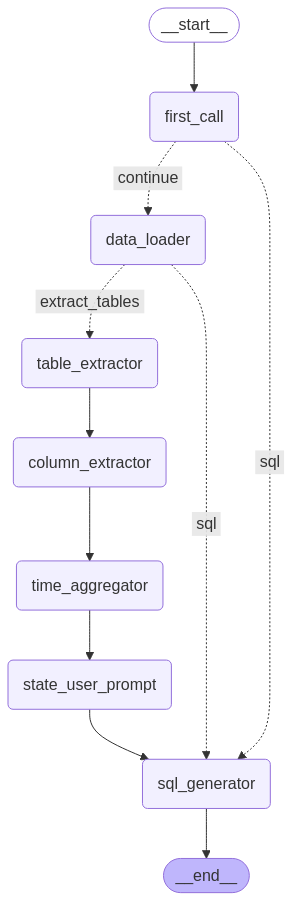

In [29]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
iterator = app.stream(initial_state)
for step in iterator:
    print("Step output:", step)